# Курсовая работа: Выдача рейтинга фильма

## Инициализация и проверка

In [94]:
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, classification_report
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig, RobertaModel, Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.9.1+cu130
CUDA available: True
GPU: NVIDIA GeForce RTX 5070 Ti
CUDA version: 13.0


## Конфиг (параметры обучения)

In [ ]:
# Конфигурация путей
ROOT = Path(".").resolve()
OUTPUT_DIR = ROOT / "Out"
DATA_DIR = ROOT / "datasets"
METADATA_CSV = DATA_DIR / "scripts_ratingss.csv"
RAW_DATA_DIR = DATA_DIR / "scenaryy"
TEST_NOINFO_DIR = DATA_DIR / "noinfo"
TEST_GOOD_DIR = DATA_DIR / "good"

# Создание директорий
for dir_path in [OUTPUT_DIR, TEST_NOINFO_DIR, TEST_GOOD_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Параметры модели
MODEL_NAME = "sberbank-ai/ruRoberta-large"
NUM_EPOCHS = 10
BATCH_SIZE = 2
WARMUP_STEPS = 100
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION_STEPS = 4
MAX_LENGTH = 512

print(f"\nРабочая директория: {ROOT}")
print(f"Директория с данными: {DATA_DIR}")


Рабочая директория: C:\Users\Дмитрий\Downloads\Ratings
Директория с данными: C:\Users\Дмитрий\Downloads\Ratings\datasets


## Загрузка и проверка данных

In [96]:
class DataLoader:
    @staticmethod
    def load_metadata(csv_path: Path) -> pd.DataFrame:
        """Загрузка метаданных из CSV"""
        try:
            df = pd.read_csv(csv_path, encoding='utf-8')
            print(f"Загружено {len(df)} записей из {csv_path.name}")
            return df
        except Exception as e:
            raise Exception(f"Ошибка загрузки CSV: {e}")
    
    @staticmethod
    def load_script_txt(file_path: Path) -> str:
        """Загрузка текста сценария с обработкой кодировок"""
        encodings = ['utf-8', 'cp1251', 'iso-8859-1', 'windows-1251']
        for encoding in encodings:
            try:
                with open(file_path, 'r', encoding=encoding) as f:
                    return f.read()
            except UnicodeDecodeError:
                continue
        raise Exception(f"Не удалось декодировать файл: {file_path.name}")

class TextPreprocessor:
    @staticmethod
    def clean_script_text(raw_text: str) -> str:
        """Очистка текста сценария"""
        text = raw_text
        
        # Удаление технической информации
        text = re.sub(r'\\r\\n', '\n', text)
        text = re.sub(r'\n{3,}', '\n\n', text)
        text = re.sub(r'[ \t]{2,}', ' ', text)
        
        # Удаление скобочных комментариев
        text = re.sub(r'\([^)]*\)', '', text)
        
        # Удаление строк только из заглавных букв (ремарки)
        text = re.sub(r'^[A-ZА-ЯЁ\s\d\-\.]+$', '', text, flags=re.MULTILINE)
        
        # Очистка от лишних символов
        text = re.sub(r'[^\w\s\.,!?;:\-\'"\n]', '', text)
        
        # Нормализация пробелов вокруг знаков препинания
        text = re.sub(r'\s+([.,!?;:])', r'\1', text)
        text = re.sub(r'([.,!?;:])\s+', r'\1 ', text)
        
        return text.strip()      

# Загрузка метаданных
metadata_df = DataLoader.load_metadata(METADATA_CSV)
print(f"\nЗагружено {len(metadata_df)} записей из {METADATA_CSV.name}")

print("\nПервые 5 записей:")
print(f"{'Файл':<40} {'Название':<30} {'Год':<6} {'KP':<6} {'IMDB':<6} {'AgeIMDB':<6} {'AgeKP':<6}")

for idx, row in metadata_df.head().iterrows():
    print(f"{row['filename'][:38]:<40} {row['title'][:28]:<30} {row['year']:<6} "
          f"{row['kp_rating']:<6.1f} {row['imdb_rating']:<6.1f} {row['age_rating_imdb']:<8}{row['age_rating_kp']:<6}")

Загружено 51 записей из scripts_ratingss.csv

Загружено 51 записей из scripts_ratingss.csv

Первые 5 записей:
Файл                                     Название                       Год    KP     IMDB   AgeIMDB AgeKP 
13_причин_почему_Кино.txt                13_причин_почему_Кино          2017   7.3    7.4    TV-MA   16+   
Игра_Престолов_Кино.txt                  Игра_Престолов_Кино            2011   9.0    9.2    TV-MA   18+   
8_миллиметров_Кино.txt                   8_миллиметров_Кино             1999   7.1    6.6    R       18+   
Джентльмены_Кино.txt                     Джентльмены_Кино               2019   8.7    7.8    R       18+   
Джокер_Кино.txt                          Джокер_Кино                    2019   8.0    8.3    R       18+   


## Подготовка датасета

In [97]:
def prepare_training_dataset(metadata_df, raw_data_dir):
    #Подготовка датасета для обучения
    processed_data = []
    
    for idx, row in metadata_df.iterrows():
        try:
            filename = str(row['filename'])
            if not filename.endswith('.txt'):
                filename += '.txt'
            
            txt_path = raw_data_dir / filename
            
            if not txt_path.exists():
                print(f"Файл не найден: {filename}")
                continue
            
            # Загрузка и очистка текста
            raw_text = DataLoader.load_script_txt(txt_path)
            cleaned_text = TextPreprocessor.clean_script_text(raw_text)
            
            if len(cleaned_text) < 1000:
                print(f"Текст слишком короткий: {filename} ({len(cleaned_text)} символов)")
                continue
            
            # Подготовка данных
            record = {
                'filename': filename,
                'title': row['title'],
                'year': int(row['year']) if pd.notna(row['year']) else 0,
                'kp_rating': float(row['kp_rating']) if pd.notna(row['kp_rating']) else 0.0,
                'imdb_rating': float(row['imdb_rating']) if pd.notna(row['imdb_rating']) else 0.0,
                'age_rating': str(row['age_rating_kp']) if pd.notna(row['age_rating_kp']) else str(row['age_rating_imdb']),
                'text': cleaned_text
            }
            
            # Обработка возрастного рейтинга
            age_rating = record['age_rating']
            if age_rating in ['R', 'TV-MA', '18+']:
                record['age_label'] = 4  # 18+
            elif age_rating in ['16+', 'TV-14']:
                record['age_label'] = 3  # 16+
            elif age_rating in ['12+', 'PG-13']:
                record['age_label'] = 2  # 12+
            elif age_rating in ['6+', 'PG']:
                record['age_label'] = 1  # 6+
            elif age_rating in ['0+', 'G']:
                record['age_label'] = 0  # 0+
            else:
                record['age_label'] = 2  # По умолчанию 12+
            
            processed_data.append(record)
            
        except Exception as e:
            print(f"Ошибка обработки файла {filename}: {e}")
            continue
    
    return pd.DataFrame(processed_data)

# Создание датасета
print("\nПодготовка датасета")
processed_df = prepare_training_dataset(metadata_df, RAW_DATA_DIR)
print(f"Создан датасет: {len(processed_df)} записей")
print(f"Средняя длина текста: {processed_df['text'].apply(len).mean():.0f} символов")

# Проверяем распределение по классам age_label
print("\nРаспределение по возрастным рейтингам:")
age_distribution = processed_df['age_label'].value_counts().sort_index()
print(age_distribution.to_string())


Подготовка датасета
Создан датасет: 51 записей
Средняя длина текста: 76027 символов

Распределение по возрастным рейтингам:
age_label
0     1
2     4
3     8
4    38


In [98]:
# Создаем более сбалансированное разделение
train_data = []
val_data = []

# Для каждого класса берем минимум 2 примера в валидацию
for age_class in processed_df['age_label'].unique():
    class_samples = processed_df[processed_df['age_label'] == age_class]
    
    if len(class_samples) >= 4:
        train_class, val_class = train_test_split(
            class_samples,
            test_size=0.25,
            random_state=42
        )
    elif len(class_samples) >= 2:
        # Для маленьких классов берем по 1 в валидацию
        train_class = class_samples.iloc[1:]
        val_class = class_samples.iloc[:1]
    else:
        # Для классов с 1 примером - весь в тренировку
        train_class = class_samples
        val_class = pd.DataFrame(columns=processed_df.columns)
    
    train_data.append(train_class)
    val_data.append(val_class)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)

print(f"\nРазделение данных:")
print(f"Тренировочная выборка: {len(train_df)} записей")
print(f"Валидационная выборка: {len(val_df)} записей")

# Проверяем распределение классов в обеих выборках
print("\nРаспределение в тренировочной выборке:")
print(train_df['age_label'].value_counts().sort_index().to_string())

print("\nРаспределение в валидационной выборке:")
print(val_df['age_label'].value_counts().sort_index().to_string())


Разделение данных:
Тренировочная выборка: 38 записей
Валидационная выборка: 13 записей

Распределение в тренировочной выборке:
age_label
0     1
2     3
3     6
4    28

Распределение в валидационной выборке:
age_label
2     1
3     2
4    10


## Загрузка модели и токенизатора

In [99]:
print("ИНИЦИАЛИЗАЦИЯ МОДЕЛИ BERT")

print(f"\nИспользуемая модель: {MODEL_NAME}")
print("Загрузка токенизатора")

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True
)

ИНИЦИАЛИЗАЦИЯ МОДЕЛИ BERT

Используемая модель: sberbank-ai/ruRoberta-large
Загрузка токенизатора


## Класс датасета

In [100]:
class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row['text'])[:5000]  # Ограничение длины для экономии памяти
        rating = float(row['kp_rating'])
        age_label = int(row['age_label'])
        
        # Токенизация
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'rating_labels': torch.tensor(rating, dtype=torch.float32),
            'age_labels': torch.tensor(age_label, dtype=torch.long)
        }

class MultitaskDataCollator:
    def __call__(self, features):
        batch = {}
        batch['input_ids'] = torch.stack([f['input_ids'] for f in features])
        batch['attention_mask'] = torch.stack([f['attention_mask'] for f in features])
        batch['rating_labels'] = torch.stack([f['rating_labels'] for f in features])
        batch['age_labels'] = torch.stack([f['age_labels'] for f in features])
        return batch

# Создание датасетов
print("СОЗДАНИЕ ДАТАСЕТОВ")
train_dataset = MovieDataset(train_df, tokenizer, max_length=MAX_LENGTH)
val_dataset = MovieDataset(val_df, tokenizer, max_length=MAX_LENGTH)

print(f"✓ Размер тренировочного датасета: {len(train_dataset)}")
print(f"✓ Размер валидационного датасета: {len(val_dataset)}")


СОЗДАНИЕ ДАТАСЕТОВ
✓ Размер тренировочного датасета: 38
✓ Размер валидационного датасета: 13


## Модель + Выборка

In [101]:
class MultitaskBERTModelWithLoRA(nn.Module):
    def __init__(self, base_model_name, num_age_classes=5, use_lora=True):
        super().__init__()
        
        # Загружаем конфигурацию модели
        config = AutoConfig.from_pretrained(base_model_name)
        
        # Создаем базовую модель BERT/RoBERTa
        self.bert = RobertaModel(config)
        
        # Инициализируем веса из предобученной модели
        pretrained_model = AutoModel.from_pretrained(base_model_name)
        self.bert.load_state_dict(pretrained_model.state_dict(), strict=False)
        
        # Применение LoRA к базовой модели
        if use_lora:
            lora_config = LoraConfig(
                r=16,
                lora_alpha=32,
                target_modules=["query", "key", "value", "dense"],
                lora_dropout=0.1,
                bias="none",
                task_type=TaskType.FEATURE_EXTRACTION,  # Исправлено: FEATURE_EXTRACTION вместо SEQ_CLS
                inference_mode=False
            )
            self.bert = get_peft_model(self.bert, lora_config)
            print("LoRA адаптеры успешно добавлены")
        
        hidden_size = config.hidden_size
        
        # Головы для регрессии и классификации
        self.rating_head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
        self.age_head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_age_classes)
        )
    
    def forward(self, input_ids=None, attention_mask=None, rating_labels=None, age_labels=None, **kwargs):
        # Фильтруем лишние аргументы, которые не нужны базовой модели
        bert_kwargs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }
        
        # Удаляем None значения
        bert_kwargs = {k: v for k, v in bert_kwargs.items() if v is not None}
        
        # Прямой проход через BERT
        outputs = self.bert(**bert_kwargs, return_dict=True)
        
        # Используем токен [CLS]
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        # Предсказания
        rating_logits = self.rating_head(pooled_output).squeeze(-1)
        age_logits = self.age_head(pooled_output)
        
        # Вычисление потерь
        loss = None
        if rating_labels is not None and age_labels is not None:
            rating_loss = nn.MSELoss()(rating_logits, rating_labels)
            age_loss = nn.CrossEntropyLoss()(age_logits, age_labels)
            loss = rating_loss + 0.3 * age_loss
        
        return {
            'loss': loss,
            'rating_logits': rating_logits,
            'age_logits': age_logits
        }

In [102]:
# Инициализация модели
print("\nИнициализация модели")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultitaskBERTModelWithLoRA(MODEL_NAME, use_lora=True).to(device)

# Вывод информации о модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров (с LoRA): {trainable_params:,}")
print(f"Процент обучаемых параметров: {trainable_params/total_params*100:.2f}%")


Инициализация модели


Some weights of RobertaModel were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA адаптеры успешно добавлены
Всего параметров: 362,733,574
Обучаемых параметров (с LoRA): 7,373,830
Процент обучаемых параметров: 2.03%


# Метрики и датасеты

In [103]:
class MultitaskTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Вычисление потерь с поддержкой новых параметров"""
        # ВАЖНОЕ ИСПРАВЛЕНИЕ: добавить параметр num_items_in_batch
        rating_labels = inputs.pop('rating_labels')
        age_labels = inputs.pop('age_labels')
        
        outputs = model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            rating_labels=rating_labels,
            age_labels=age_labels
        )
        
        loss = outputs['loss']
        return (loss, outputs) if return_outputs else loss

def compute_multitask_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Обработка predictions
    if isinstance(predictions, tuple) and len(predictions) == 2:
        rating_preds, age_preds = predictions
    else:
        rating_preds = predictions
        age_preds = None
    
    # Обработка labels
    if isinstance(labels, tuple) and len(labels) == 2:
        rating_labels, age_labels = labels
    else:
        rating_labels = labels
        age_labels = None
    
    # Преобразуем age_preds в метки классов
    if age_preds is not None and len(age_preds.shape) > 1:
        age_preds = np.argmax(age_preds, axis=1)
    
    # Вычисляем метрики для рейтинга
    rating_mae = mean_absolute_error(rating_labels, rating_preds)
    rating_rmse = np.sqrt(mean_squared_error(rating_labels, rating_preds))
    
    # Вычисляем метрики для возрастного рейтинга
    age_metrics = {}
    if age_labels is not None and age_preds is not None:
        age_accuracy = accuracy_score(age_labels, age_preds)
        age_f1 = f1_score(age_labels, age_preds, average='weighted', zero_division=0)
        
        age_metrics = {
            'age_accuracy': age_accuracy,
            'age_f1': age_f1,
        }
    
    return {
        'rating_mae': rating_mae,
        'rating_rmse': rating_rmse,
        **age_metrics
    }

## Обучение на тренировочных данных

In [125]:
# Параметры обучения
training_args = TrainingArguments(
    output_dir=str(OUTPUT_DIR / "model"),
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    learning_rate=2e-5,
    logging_dir=str(OUTPUT_DIR / "logs"),
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="none",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    remove_unused_columns=False,
)

# Создаем Trainer
trainer = MultitaskTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_multitask_metrics,
    data_collator=MultitaskDataCollator(),
)

# Обучаем модель
print("Начало обучения")
train_results = trainer.train()

# Сохраняем модель
print("Cохранение модели")
trainer.save_model(str(OUTPUT_DIR / "model"))
tokenizer.save_pretrained(str(OUTPUT_DIR / "model" / "tokenizer"))

print(f"✓ Модель сохранена в: {OUTPUT_DIR / 'model'}")

# Выводим результаты обучения
print("Результаты обучения:")
if hasattr(trainer, 'state') and trainer.state.log_history:
    for log in trainer.state.log_history[-5:]:
        if 'loss' in log:
            epoch = log.get('epoch', '?')
            loss = log.get('loss', '?')
            print(f"  Эпоха {epoch}: loss = {loss:.4f}" if isinstance(loss, float) else f"  Эпоха {epoch}: loss = {loss}")


Начало обучения


Epoch,Training Loss,Validation Loss,Rating Mae,Rating Rmse,Age Accuracy,Age F1
1,No log,4.587589,1.865505,2.074347,0.769231,0.668896
2,5.423200,4.496161,1.844471,2.052295,0.769231,0.668896
3,5.423200,4.338166,1.806911,2.013700,0.769231,0.668896
4,4.867600,4.126382,1.755529,1.960872,0.769231,0.668896
5,4.867600,3.856346,1.686719,1.891355,0.769231,0.668896
6,4.218500,3.548682,1.604086,1.808953,0.769231,0.668896
7,4.218500,3.206540,1.513822,1.712764,0.769231,0.668896
8,3.524900,2.859624,1.423978,1.609436,0.769231,0.668896
9,3.524900,2.517391,1.325421,1.500492,0.769231,0.668896
10,2.887300,2.196202,1.220252,1.390704,0.769231,0.668896


Cохранение модели
✓ Модель сохранена в: C:\Users\Дмитрий\Downloads\Ratings\Out\model
Результаты обучения:
  Эпоха 10.0: loss = 2.8873


Найдено 5 записей тренировочных потерь
Найдено 10 записей валидационных потерь


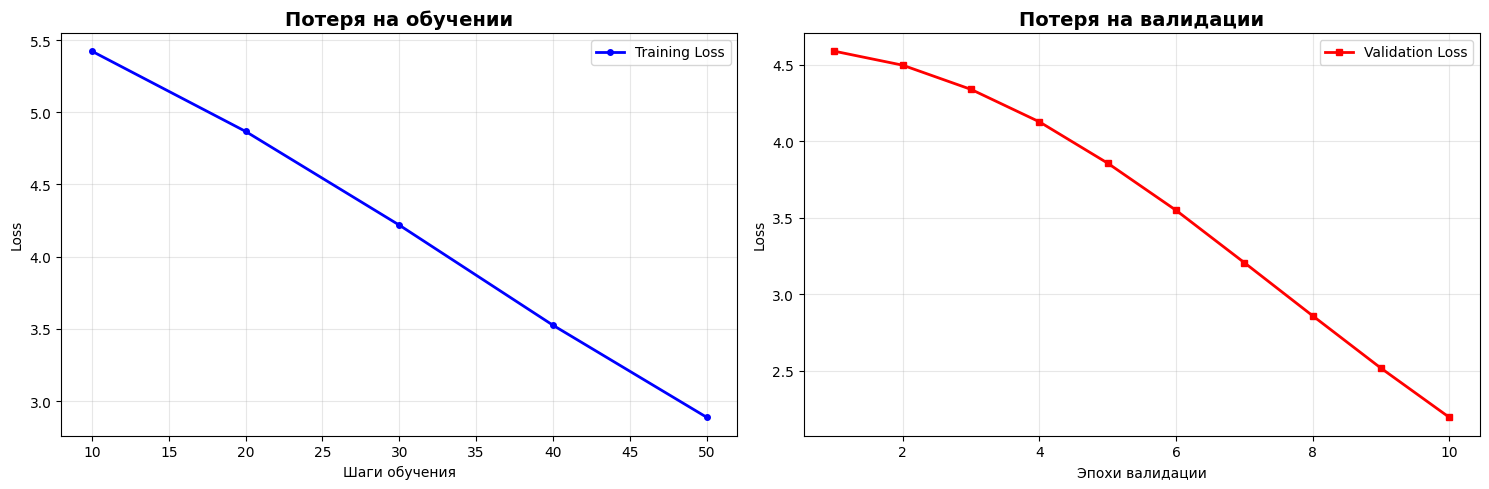

In [126]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 5)

# Извлекаем данные из log_history

train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

if hasattr(trainer, 'state') and trainer.state.log_history:
    for log in trainer.state.log_history:
        # Training logs содержат 'loss'
        if 'loss' in log and 'eval_loss' not in log:
            train_losses.append(log['loss'])
            train_steps.append(log.get('step', len(train_losses)))
        # Evaluation logs содержат 'eval_loss'
        elif 'eval_loss' in log:
            eval_losses.append(log['eval_loss'])
            eval_steps.append(log.get('epoch', len(eval_losses)))

print(f"Найдено {len(train_losses)} записей тренировочных потерь")
print(f"Найдено {len(eval_losses)} записей валидационных потерь")

# График 1: Loss по эпохам
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

if train_losses:
    ax1.plot(train_steps, train_losses, 'b-o', linewidth=2, markersize=4, label='Training Loss')
    ax1.set_title('Потеря на обучении', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Шаги обучения')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
else:
    ax1.text(0.5, 0.5, 'Нет данных о тренировочных потерях', 
             ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Потеря на обучении', fontsize=14, fontweight='bold')

if eval_losses:
    ax2.plot(eval_steps, eval_losses, 'r-s', linewidth=2, markersize=4, label='Validation Loss')
    ax2.set_title('Потеря на валидации', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Эпохи валидации')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
else:
    ax2.text(0.5, 0.5, 'Нет данных о валидационных потерях', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Потеря на валидации', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

### Обучалка

In [127]:
print("ОЦЕНКА НА ВАЛИДАЦИОННОМ НАБОРЕ")

# Функция для предсказания на одном тексте
def predict_single_text(text, model, tokenizer, device, max_length=512):
    cleaned_text = TextPreprocessor.clean_script_text(text)
    
    # Токенизация
    encoding = tokenizer(
        cleaned_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Перенос на устройство
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Предсказание
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Извлечение результатов
    rating_pred = outputs['rating_logits'].item()
    age_pred = torch.argmax(outputs['age_logits'], dim=1).item()
    
    # Преобразование возрастного рейтинга
    age_mapping = {0: "0+", 1: "6+", 2: "12+", 3: "16+", 4: "18+"}
    age_rating = age_mapping.get(age_pred, "12+")
    
    return {
        'predicted_rating': round(rating_pred, 2),
        'predicted_age_rating': age_rating,
        'text_length': len(cleaned_text)
    }

# Получаем предсказания для валидационных фильмов
rating_preds = []
age_preds_labels = []

for idx, row in val_df.iterrows():
    text = str(row['text'])
    prediction = predict_single_text(text, model, tokenizer, device, MAX_LENGTH)
    
    # Обратное преобразование возраста для сравнения
    age_mapping_inv = {"0+": 0, "6+": 1, "12+": 2, "16+": 3, "18+": 4}
    age_pred_label = age_mapping_inv[prediction['predicted_age_rating']]
    
    rating_preds.append(prediction['predicted_rating'])
    age_preds_labels.append(age_pred_label)

rating_labels = val_df['kp_rating'].values
age_labels = val_df['age_label'].values

age_labels = np.array(age_labels, dtype=int)
age_preds_labels = np.array(age_preds_labels, dtype=int)

# Создание DataFrame с результатами
results_df = pd.DataFrame({
    'title': val_df['title'].values,
    'actual_rating': rating_labels,
    'predicted_rating': rating_preds,
    'rating_error': np.abs(rating_labels - rating_preds),
    'actual_age': age_labels,
    'predicted_age': age_preds_labels,
    'age_correct': (age_labels == age_preds_labels).astype(int)
})

# Вывод таблицы с результатами
print("ТАБЛИЦА РЕЗУЛЬТАТОВ ВАЛИДАЦИИ")
print(f"{'Фильм':<40} {'Реальный':<12} {'Предсказ.':<12} {'Ошибка':<10} {'Возраст':<12} {'Совпад.':<8}")
print("-"*100)

age_label_map = {0: "0+", 1: "6+", 2: "12+", 3: "16+", 4: "18+"}

for idx, row in results_df.iterrows():
    age_match = "✓" if row['age_correct'] else "✗"
    actual_age_str = age_label_map.get(int(row['actual_age']), str(row['actual_age']))
    predicted_age_str = age_label_map.get(int(row['predicted_age']), str(row['predicted_age']))
    
    print(f"{str(row['title'])[:38]:<40} {row['actual_rating']:<12.2f} {row['predicted_rating']:<12.2f} "
          f"{row['rating_error']:<10.2f} {actual_age_str:<4}->{predicted_age_str:<5} {age_match:<8}")

print("СТАТИСТИКА ВАЛИДАЦИИ")

rating_mae = mean_absolute_error(rating_labels, rating_preds)
rating_mse = mean_squared_error(rating_labels, rating_preds)
rating_rmse = np.sqrt(rating_mse)

age_labels = age_labels.astype(int)
age_preds_labels = age_preds_labels.astype(int)

age_accuracy = accuracy_score(age_labels, age_preds_labels)
age_precision = precision_score(age_labels, age_preds_labels, average='weighted', zero_division=0)
age_recall = recall_score(age_labels, age_preds_labels, average='weighted', zero_division=0)
age_f1 = f1_score(age_labels, age_preds_labels, average='weighted', zero_division=0)

# Таблица метрик
metrics_table = pd.DataFrame({
    'Метрика': ['MAE рейтинга', 'MSE рейтинга', 'RMSE рейтинга', 
                'Accuracy возраста', 'Precision возраста', 'Recall возраста', 'F1-Score возраста'],
    'Значение': [
        f"{rating_mae:.4f}",
        f"{rating_mse:.4f}",
        f"{rating_rmse:.4f}",
        f"{age_accuracy:.4f}",
        f"{age_precision:.4f}",
        f"{age_recall:.4f}",
        f"{age_f1:.4f}"
    ]
})

print(" СВОДНЫЕ МЕТРИКИ:")
print(metrics_table.to_string(index=False))

print(" ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ:")
unique_labels = np.unique(np.concatenate([age_labels, age_preds_labels]))
target_names = [age_label_map.get(label, str(label)) for label in sorted(unique_labels)]
print(classification_report(age_labels, age_preds_labels, 
                           target_names=target_names, zero_division=0))

results_df.to_csv(OUTPUT_DIR / "validation_results.csv", index=False, encoding='utf-8')
print(f"Результаты валидации сохранены в: {OUTPUT_DIR / 'validation_results.csv'}")


ОЦЕНКА НА ВАЛИДАЦИОННОМ НАБОРЕ
ТАБЛИЦА РЕЗУЛЬТАТОВ ВАЛИДАЦИИ
Фильм                                    Реальный     Предсказ.    Ошибка     Возраст      Совпад. 
----------------------------------------------------------------------------------------------------
Железный_человек_Кино                    8.00         6.66         1.34       16+ ->18+   ✗       
Марки_Кино                               7.70         6.63         1.07       16+ ->18+   ✗       
Паразиты_Кино                            8.10         6.63         1.47       18+ ->18+   ✓       
Рик_и_Морти_Кино                         8.90         6.55         2.35       18+ ->18+   ✓       
Довод_Кино                               7.50         6.58         0.92       18+ ->18+   ✓       
Продавец_правды_Кино                     6.20         6.67         0.47       18+ ->18+   ✓       
Во_Все_Тяжкие_Кино                       8.90         6.67         2.23       18+ ->18+   ✓       
Половое_воспитание_Кино                  5.50

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ВАЛИДАЦИИ


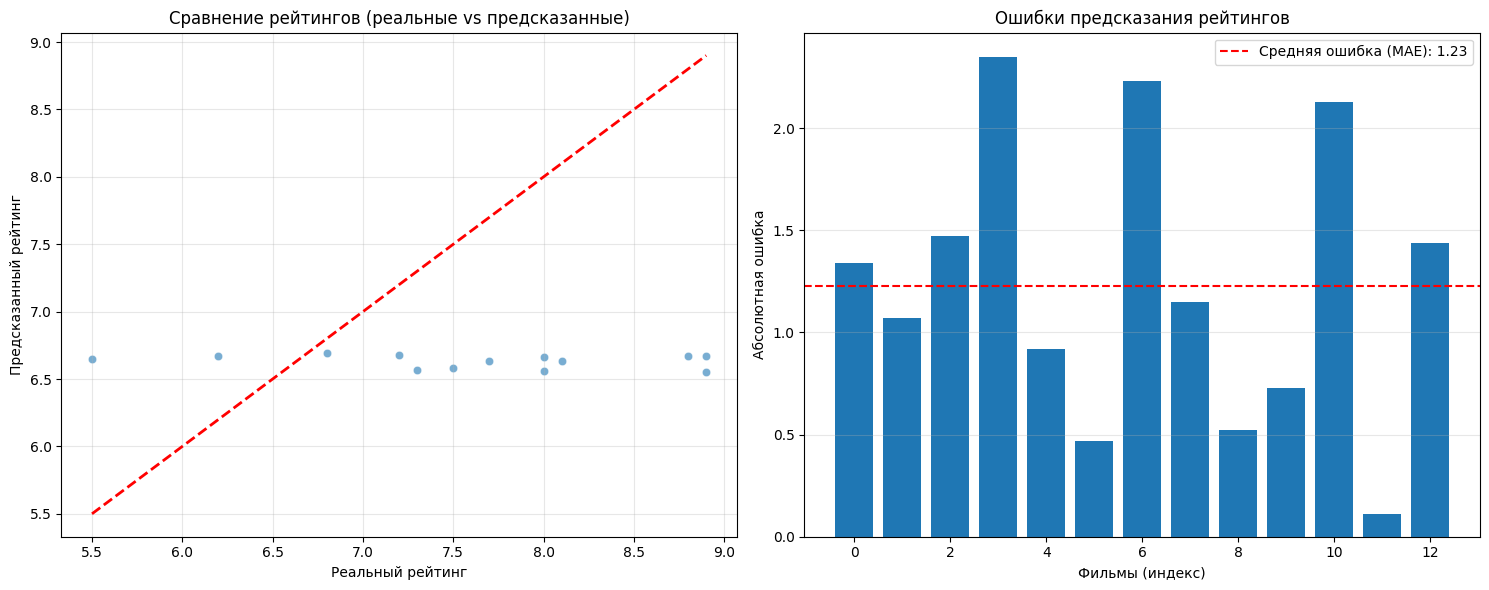

In [128]:
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ВАЛИДАЦИИ")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Сравнение реальных и предсказанных рейтингов
axes[0].scatter(rating_labels, rating_preds, alpha=0.6, edgecolors='w', linewidth=0.5)
axes[0].plot([min(rating_labels), max(rating_labels)], 
                [min(rating_labels), max(rating_labels)], 
                'r--', linewidth=2)
axes[0].set_xlabel('Реальный рейтинг')
axes[0].set_ylabel('Предсказанный рейтинг')
axes[0].set_title('Сравнение рейтингов (реальные vs предсказанные)')
axes[0].grid(True, alpha=0.3)

# График 2: Ошибки предсказания рейтингов
axes[1].bar(range(len(results_df)), results_df['rating_error'])
axes[1].set_xlabel('Фильмы (индекс)')
axes[1].set_ylabel('Абсолютная ошибка')
axes[1].set_title('Ошибки предсказания рейтингов')
axes[1].axhline(y=rating_mae, color='r', linestyle='--', 
                   label=f'Средняя ошибка (MAE): {rating_mae:.2f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'validation_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Тесты

In [129]:
def test_on_files(test_dir, model, tokenizer, device):
    """Тестирование модели на файлах из директории"""
    print(f"\n{'='*100}")
    print(f"ТЕСТИРОВАНИЕ НА ПАПКЕ: {test_dir.name}")
    print(f"{'='*100}")
    
    results = []
    test_files = list(test_dir.glob("*.txt"))
    
    if not test_files:
        print(f"Файлы не найдены в директории {test_dir}")
        return pd.DataFrame()
    
    print(f"Найдено файлов: {len(test_files)}")
    
    for i, test_file in enumerate(test_files, 1):
        try:
            print(f"\n[{i}/{len(test_files)}] Обработка файла: {test_file.name}")
            
            # Загрузка текста
            raw_text = DataLoader.load_script_txt(test_file)
            
            # Предсказание
            prediction = predict_single_text(raw_text, model, tokenizer, device, MAX_LENGTH)
            
            results.append({
                'filename': test_file.name,
                **prediction
            })
            
            print(f"  ✓ Рейтинг: {prediction['predicted_rating']}")
            print(f"  ✓ Возраст: {prediction['predicted_age_rating']}")
            print(f"  ✓ Длина: {prediction['text_length']:,} символов")
            
        except Exception as e:
            print(f"  ✗ Ошибка: {e}")
    
    if results:
        results_df = pd.DataFrame(results)
        
        # Вывод результатов
        print("\n" + "="*80)
        print("РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ")
        print("="*80)
        print(f"{'Файл':<35} {'Рейтинг':<12} {'Возраст':<12} {'Длина текста':<15}")
        print("-"*80)
        
        for idx, row in results_df.iterrows():
            print(f"{row['filename'][:32]:<35} {row['predicted_rating']:<12.2f} "
                  f"{row['predicted_age_rating']:<12} {row['text_length']:<15,}")
        
        # Сохранение результатов
        results_path = OUTPUT_DIR / f"{test_dir.name}_predictions.csv"
        results_df.to_csv(results_path, index=False, encoding='utf-8')
        print(f" Результаты сохранены в: {results_path}")
        
        return results_df
    else:
        print("\nНет результатов для анализа")
        return pd.DataFrame()

# Тестирование на обоих папках
print("\n" + "="*100)
print("ТЕСТИРОВАНИЕ НА ОТДЕЛЬНЫХ ФАЙЛАХ")
print("="*100)

results_noinfo = test_on_files(TEST_NOINFO_DIR, model, tokenizer, device)
results_good = test_on_files(TEST_GOOD_DIR, model, tokenizer, device)



ТЕСТИРОВАНИЕ НА ОТДЕЛЬНЫХ ФАЙЛАХ

ТЕСТИРОВАНИЕ НА ПАПКЕ: noinfo
Найдено файлов: 3

[1/3] Обработка файла: Анатидаефобия_Кино.txt
  ✓ Рейтинг: 6.69
  ✓ Возраст: 18+
  ✓ Длина: 8,431 символов

[2/3] Обработка файла: Прокрастинация_Кино.txt
  ✓ Рейтинг: 6.65
  ✓ Возраст: 18+
  ✓ Длина: 5,822 символов

[3/3] Обработка файла: Ширванская_сказка_Кино.txt
  ✓ Рейтинг: 6.66
  ✓ Возраст: 18+
  ✓ Длина: 79,360 символов

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ
Файл                                Рейтинг      Возраст      Длина текста   
--------------------------------------------------------------------------------
Анатидаефобия_Кино.txt              6.69         18+          8,431          
Прокрастинация_Кино.txt             6.65         18+          5,822          
Ширванская_сказка_Кино.txt          6.66         18+          79,360         
 Результаты сохранены в: C:\Users\Дмитрий\Downloads\Ratings\Out\noinfo_predictions.csv

ТЕСТИРОВАНИЕ НА ПАПКЕ: good
Найдено файлов: 3

[1/3] Обработка файла: dmb_snegiri

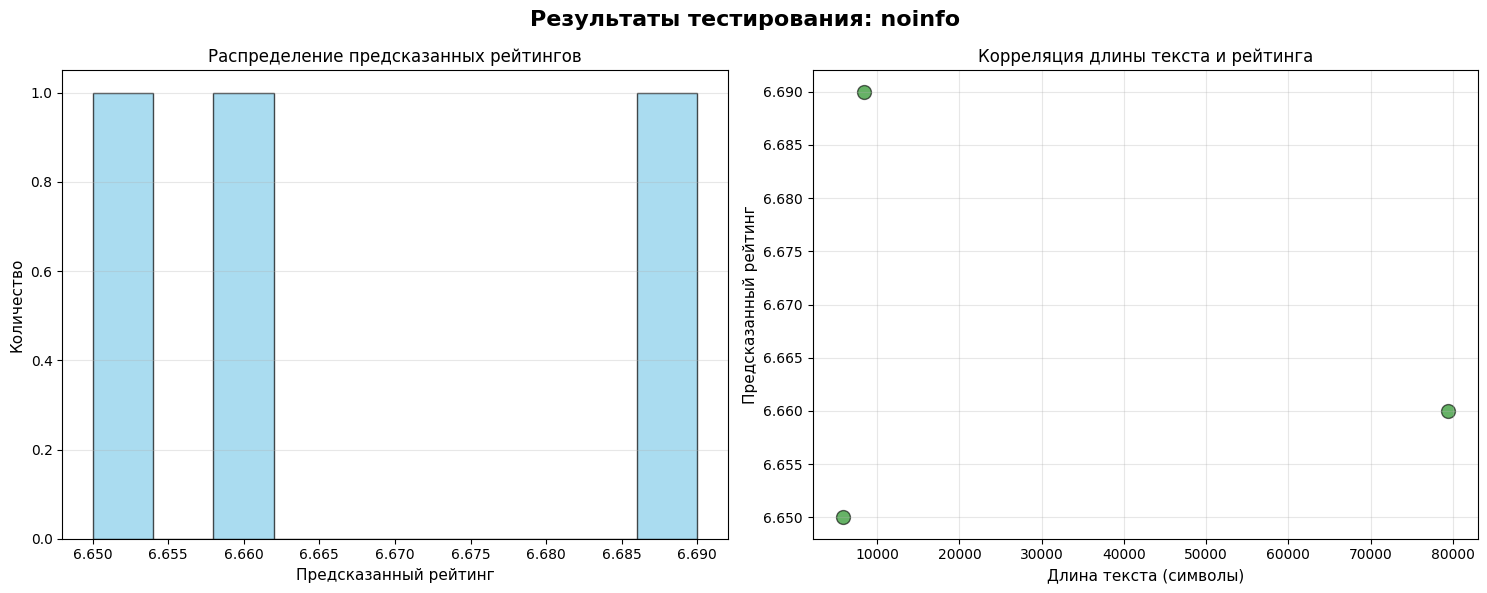

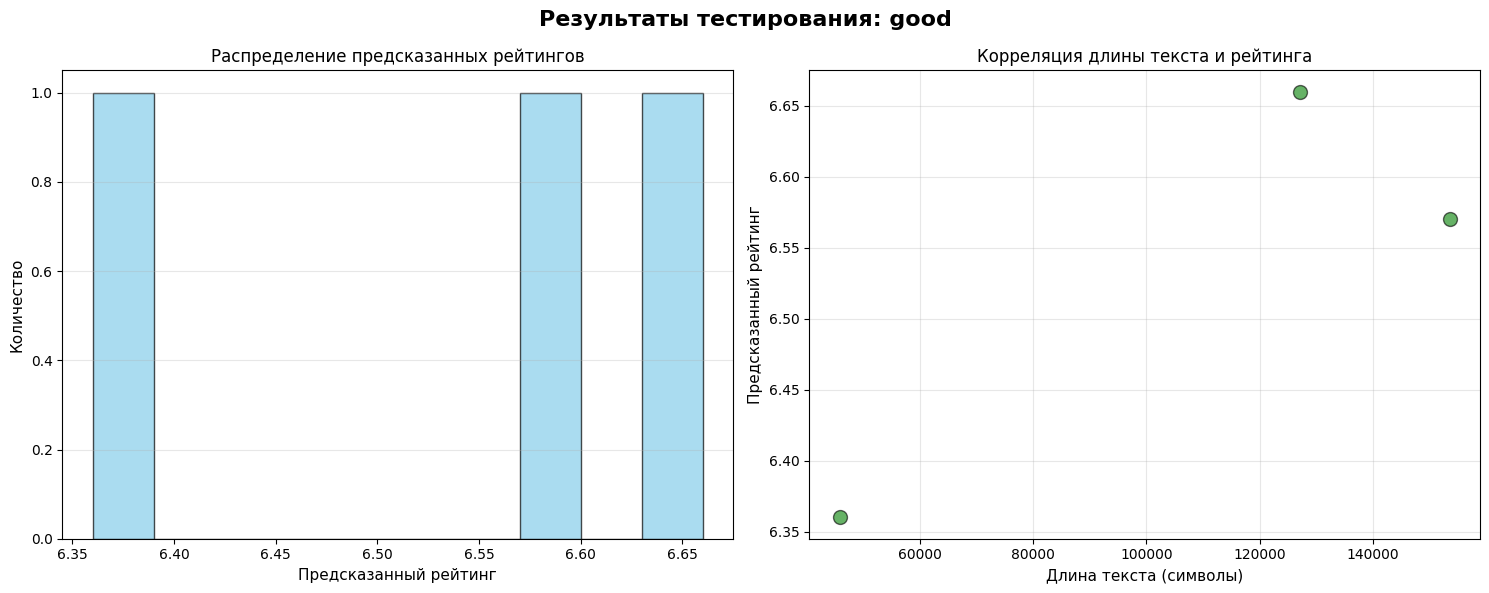

 Все графики сохранены в директорию: C:\Users\Дмитрий\Downloads\Ratings\Out


In [130]:
def visualize_test_results(results_df, title):
    """Визуализация результатов тестирования"""
    if results_df.empty:
        print(f"Нет данных для визуализации: {title}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    axes[0].hist(results_df['predicted_rating'], bins=10, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Предсказанный рейтинг', fontsize=11)
    axes[0].set_ylabel('Количество', fontsize=11)
    axes[0].set_title('Распределение предсказанных рейтингов', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='y')
        
    if 'text_length' in results_df.columns:
        axes[1].scatter(results_df['text_length'], results_df['predicted_rating'], 
                          alpha=0.6, color='green', s=100, edgecolor='black')
        axes[1].set_xlabel('Длина текста (символы)', fontsize=11)
        axes[1].set_ylabel('Предсказанный рейтинг', fontsize=11)
        axes[1].set_title('Корреляция длины текста и рейтинга', fontsize=12)
        axes[1].grid(True, alpha=0.3)
    
        
    plt.tight_layout()
    safe_title = title.replace(" ", "_").replace(":", "")
    plt.savefig(OUTPUT_DIR / f'{safe_title}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Визуализация
if not results_noinfo.empty:
    visualize_test_results(results_noinfo, "Результаты тестирования: noinfo")

if not results_good.empty:
    visualize_test_results(results_good, "Результаты тестирования: good")

print(" Все графики сохранены в директорию:", OUTPUT_DIR)


In [131]:
print("ИТОГОВЫЙ ОТЧЕТ")

summary_data = {
    'Метрика': [
        'Тренировочная выборка',
        'Валидационная выборка',
        'MAE рейтинга (валидация)',
        'RMSE рейтинга (валидация)',
        'Accuracy возраста (валидация)',
        'F1-Score возраста (валидация)'
    ],
    'Значение': [
        f"{len(train_df)} записей",
        f"{len(val_df)} записей",
        f"{rating_mae:.4f}",
        f"{rating_rmse:.4f}",
        f"{age_accuracy:.2%}",
        f"{age_f1:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(" ПАРАМЕТРЫ И РЕЗУЛЬТАТЫ:")
print(summary_df.to_string(index=False))

# Сохранение итогового отчета
summary_df.to_csv(OUTPUT_DIR / "summary_report.csv", index=False, encoding='utf-8')

print(f" Все результаты сохранены в директорию: {OUTPUT_DIR}")
print(f"  - Обученная модель: {OUTPUT_DIR}/model/")
print(f"  - История обучения: {OUTPUT_DIR}/training_history.png")
print(f"  - Результаты валидации: {OUTPUT_DIR}/validation_results_plots.png")
print(f"  - CSV результатов валидации: {OUTPUT_DIR}/validation_results.csv")
print(f"  - Результаты тестирования noinfo: {OUTPUT_DIR}/noinfo_predictions.csv")
print(f"  - Результаты тестирования good: {OUTPUT_DIR}/good_predictions.csv")
print(f"  - Итоговый отчет: {OUTPUT_DIR}/summary_report.csv")



ИТОГОВЫЙ ОТЧЕТ
 ПАРАМЕТРЫ И РЕЗУЛЬТАТЫ:
                      Метрика   Значение
        Тренировочная выборка 38 записей
        Валидационная выборка 13 записей
     MAE рейтинга (валидация)     1.2254
    RMSE рейтинга (валидация)     1.3981
Accuracy возраста (валидация)     76.92%
F1-Score возраста (валидация)     0.6689
 Все результаты сохранены в директорию: C:\Users\Дмитрий\Downloads\Ratings\Out
  - Обученная модель: C:\Users\Дмитрий\Downloads\Ratings\Out/model/
  - История обучения: C:\Users\Дмитрий\Downloads\Ratings\Out/training_history.png
  - Результаты валидации: C:\Users\Дмитрий\Downloads\Ratings\Out/validation_results_plots.png
  - CSV результатов валидации: C:\Users\Дмитрий\Downloads\Ratings\Out/validation_results.csv
  - Результаты тестирования noinfo: C:\Users\Дмитрий\Downloads\Ratings\Out/noinfo_predictions.csv
  - Результаты тестирования good: C:\Users\Дмитрий\Downloads\Ratings\Out/good_predictions.csv
  - Итоговый отчет: C:\Users\Дмитрий\Downloads\Ratings\Out/summar